Text(0.5, 1.0, 'Gaussian (or Normal) Distribution: $y \\sim \\mathcal{N}(\\mu,\\Sigma)$')

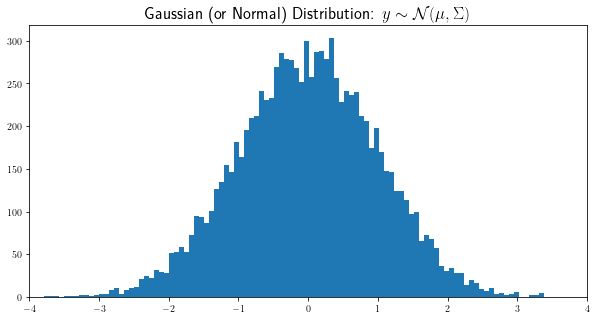

In [22]:
import torch
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

pdist = torch.normal(0,1, size=(1, 10000))  #play with the standar deviation to see the effect over the distribution

plt.figure(figsize=(10,5))
plt.hist(pdist,bins=100)

plt.xlim([-4,4])
plt.title(r'Gaussian (or Normal) Distribution: $y \sim \mathcal{N}(\mu,\Sigma)$',fontsize=17)

y=[-0.05839904] and x=[0.4]


Text(0, 0.5, '$y \\sim \\mathcal{N}(f(x),\\Sigma)$')

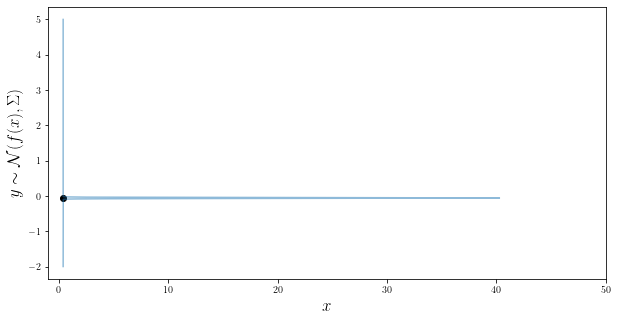

In [23]:
from scipy.stats import norm
import numpy as np

f = lambda x:2*np.cos(4*x)
x = np.array([0.4]) 
#x = torch.linspace(0,1,1)[:,None]
#x = torch.rand(10)[:,None]
y = f(x) 
#torch.sin(x)
plt.figure(figsize=(10,5))
plt.plot(x,y,'ko')
print(f"y={y} and x={x}")

xrange = np.linspace(-2,5,10000)
sig2 = 0.0001  #play with this sig2 to plot different types of Gaussian distributions over the y value
pdf = norm.pdf(xrange,loc=y.flatten(),scale=np.sqrt(sig2))
#plt.plot(x,pdf)
plt.plot(pdf+x,xrange,alpha=0.5)
plt.xlim([-1,0.5/np.sqrt(sig2)])
plt.xlabel(r'$x$',fontsize=17)
plt.ylabel(r'$y \sim \mathcal{N}(f(x),\Sigma)$',fontsize=17)

[[ 2.        ]
 [ 1.80569934]
 [ 1.2605501 ]
 [ 0.47047515]
 [-0.41101344]
 [-1.21264184]
 [-1.77865314]
 [-1.99907095]
 [-1.83106795]
 [-1.30728724]]


Text(0, 0.5, '$y \\sim \\mathcal{N}(f(x),\\Sigma\\rightarrow 0)$')

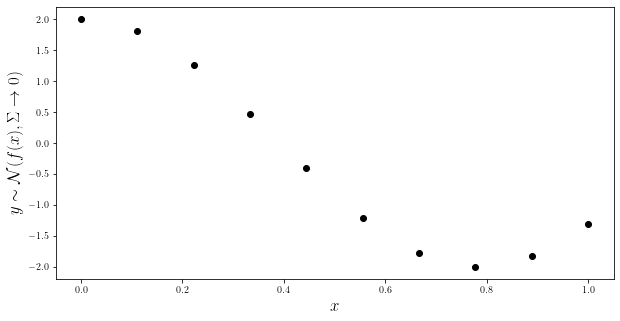

In [28]:
f = lambda x:2*np.cos(4*x)
x = np.linspace(0,1,10)[:,None]   #Here increase the number of N for the linspace to see the effect of more points
y = f(x) 

plt.figure(figsize=(10,5))
plt.plot(x,y,'ko')
#plt.ylim([1.8,2.1])
print(y)
plt.xlabel(r'$x$',fontsize=17)
plt.ylabel(r'$y \sim \mathcal{N}(f(x),\Sigma\rightarrow 0)$',fontsize=17)

In [25]:
def covar(x1):
    x2 = x1.copy()
    x1_m,x2_m = np.meshgrid(x1,x2)
    sig = 0.00005  #Play with this value to see how the covariance increases or decreases its values
    kxx = sig*np.exp(-0.5/(0.1)*(x1_m-x2_m)**2)
    return kxx

cov = covar(x)
print(f"mean:\n{y}\n")
print(f"(Co)variance:\n{cov}")

mean:
[[ 2.        ]
 [ 1.80569934]
 [ 1.2605501 ]
 [ 0.47047515]
 [-0.41101344]
 [-1.21264184]
 [-1.77865314]
 [-1.99907095]
 [-1.83106795]
 [-1.30728724]]

(Co)variance:
[[5.00000000e-05 4.70069099e-05 3.90604101e-05 2.86876710e-05
  1.86224657e-05 1.06847034e-05 5.41840116e-06 2.42864053e-06
  9.62140991e-07 3.36897350e-07]
 [4.70069099e-05 5.00000000e-05 4.70069099e-05 3.90604101e-05
  2.86876710e-05 1.86224657e-05 1.06847034e-05 5.41840116e-06
  2.42864053e-06 9.62140991e-07]
 [3.90604101e-05 4.70069099e-05 5.00000000e-05 4.70069099e-05
  3.90604101e-05 2.86876710e-05 1.86224657e-05 1.06847034e-05
  5.41840116e-06 2.42864053e-06]
 [2.86876710e-05 3.90604101e-05 4.70069099e-05 5.00000000e-05
  4.70069099e-05 3.90604101e-05 2.86876710e-05 1.86224657e-05
  1.06847034e-05 5.41840116e-06]
 [1.86224657e-05 2.86876710e-05 3.90604101e-05 4.70069099e-05
  5.00000000e-05 4.70069099e-05 3.90604101e-05 2.86876710e-05
  1.86224657e-05 1.06847034e-05]
 [1.06847034e-05 1.86224657e-05 2.86876710e

Text(0, 0.5, '$y \\sim \\mathcal{N}(f(x),\\Sigma)$')

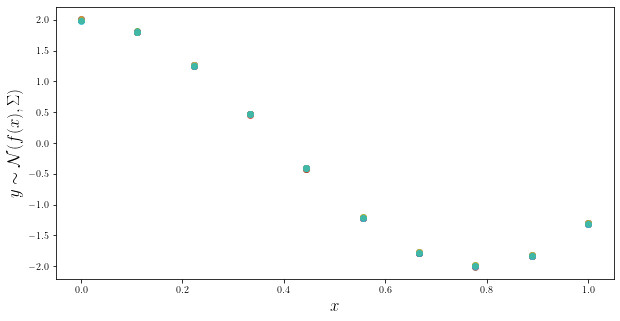

In [27]:
plt.figure(figsize=(10,5))
Nsamples = 10
for i in range(Nsamples):
    
    # Uncomment the first line below to use only diag of covariance
    # or Uncomment second line for use complete covariance
    
    #ysample = np.random.multivariate_normal(y.flatten(), np.diag(np.diag(cov))) 
    ysample = np.random.multivariate_normal(y.flatten(), cov) 
    plt.plot(x,ysample,'o',alpha=0.7)
    
#plt.ylim([1.5,2.2])
#plt.ylim([-2.2,2.2])
plt.xlabel(r'$x$',fontsize=17)
plt.ylabel(r'$y \sim \mathcal{N}(f(x),\Sigma)$',fontsize=17)

# How do we use our data for fitting a GP model?

In [16]:
#The code of this cell is just for correcting the Covariance matrix when becoming Non-positive definite
import torch
from torch import nn, optim
import gpytorch
import matplotlib.pyplot as plt
from gpytorch.utils.cholesky import psd_safe_cholesky

from numpy import linalg as la
import numpy as np

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    if isPD(A):
        return A

    print("Correcting Matrix to be PSD!!")
    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [20]:
class LogMarginalLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,L,y):
        alpha = torch.linalg.solve(L.t(), torch.linalg.solve(L, y))
        N = y.shape[0]
        return -0.5*torch.matmul(y.t(),alpha)-torch.diag(L).log().sum()-N*0.5*torch.log(torch.tensor([2*torch.pi]))

class GaussianProcess(nn.Module):
    def __init__(self,x,y):
        super().__init__()
        self.x = x
        self.y = y
        self.covariance = gpytorch.kernels.RBFKernel()
        self.Train_mode = True
        self.lik_std_noise = torch.nn.Parameter(torch.tensor([1.0])) #torch.tensor([0.07])
        self.L = torch.eye(y.shape[0])
    def forward(self,x, noiseless = True):
        if self.Train_mode:
            Knn = self.covariance(x).evaluate() #+ 1e-3*torch.eye(x.shape[0])
            Knn_noise = Knn + self.lik_std_noise.pow(2)*torch.eye(Knn.shape[0])
            self.L = torch.linalg.cholesky(Knn_noise)
            #self.L = psd_safe_cholesky(Knn_noise,jitter=1e-5)
            return self.L  #here we might return the mean and covariance (or just covar if mean is zeros)
        else:
            alpha1 = torch.linalg.solve(self.L, self.y)
            alpha = torch.linalg.solve(self.L.t(), alpha1)
            K_xnew_x = self.covariance(x,self.x).evaluate()
            K_xnew_xnew = self.covariance(x).evaluate()
            f_mu = torch.matmul(K_xnew_x,alpha)
            v = torch.linalg.solve(self.L,K_xnew_x.t())
            if noiseless:
                f_Cov = K_xnew_xnew - torch.matmul(v.t(),v) #+ 1e-5*torch.eye(x.shape[0])  #I had to add this Jitter
                f_Cov = torch.from_numpy(nearestPD(f_Cov.numpy()))
            else:
                f_Cov = K_xnew_xnew - torch.matmul(v.t(), v) + self.lik_std_noise.pow(2) * torch.eye(x.shape[0]) #+ 1e-5*torch.eye(x.shape[0])
                f_Cov = torch.from_numpy(nearestPD(f_Cov.numpy()))
            return f_mu, f_Cov

Nseed = 6
torch.manual_seed(Nseed)
import random
random.seed(Nseed)
x = torch.rand(10,1)   #play with the number of data observations here to see the effects when fitting the GP
y = torch.exp(1*x)*torch.sin(10*x)*torch.cos(3*x) + 0.1*torch.rand(*x.shape)

model = GaussianProcess(x,y)
#model.covariance.lengthscale=0.1  #If you want to initialize your lengthscale parameter uncomment

"Training process below"
myLr = 1e-2
Niter = 500
optimizer = optim.Adam(model.parameters(),lr=myLr)
loss_fn = LogMarginalLikelihood()

for iter in range(Niter):
    # Forward pass
    L = model(x)

    # Backprop
    loss = -loss_fn(L,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Loss: {loss.item()}")


"Here we have to assign the flag to change from self.Train_mode = True to False"
print("check difference between model.eval and model.train")
model.eval()
model.Train_mode = False
x_test = torch.linspace(0, 1, 100)[:,None]
with torch.no_grad():
    #mpred1,Cpred1 = model(x)
    mpred, Cpred = model(x_test,noiseless=True)


Loss: 12.753877639770508
Loss: 12.706443786621094
Loss: 12.659421920776367
Loss: 12.612852096557617
Loss: 12.566781997680664
Loss: 12.521257400512695
Loss: 12.47632884979248
Loss: 12.432052612304688
Loss: 12.388484954833984
Loss: 12.345685958862305
Loss: 12.303720474243164
Loss: 12.262655258178711
Loss: 12.222558975219727
Loss: 12.183505058288574
Loss: 12.145570755004883
Loss: 12.108833312988281
Loss: 12.073372840881348
Loss: 12.039270401000977
Loss: 12.006608963012695
Loss: 11.975469589233398
Loss: 11.94593334197998
Loss: 11.918076515197754
Loss: 11.891975402832031
Loss: 11.867694854736328
Loss: 11.845294952392578
Loss: 11.824827194213867
Loss: 11.80632495880127
Loss: 11.78980827331543
Loss: 11.77528190612793
Loss: 11.762723922729492
Loss: 11.752092361450195
Loss: 11.743317604064941
Loss: 11.736303329467773
Loss: 11.730926513671875
Loss: 11.72703742980957
Loss: 11.724458694458008
Loss: 11.722996711730957
Loss: 11.722440719604492
Loss: 11.722569465637207
Loss: 11.723165512084961
Loss: 

Loss: 4.7575531005859375
Loss: 4.75288200378418
Loss: 4.748191833496094
Loss: 4.743492603302002
Loss: 4.738772392272949
Loss: 4.734004974365234
Loss: 4.729256629943848
Loss: 4.724457740783691
Loss: 4.719658374786377
Loss: 4.714825630187988
Loss: 4.709964752197266
Loss: 4.705099582672119
Loss: 4.700211524963379
Loss: 4.695289611816406
Loss: 4.690354347229004
Loss: 4.685397624969482
Loss: 4.680428504943848
Loss: 4.675413608551025
Loss: 4.670388221740723
Loss: 4.665340423583984
Loss: 4.660266876220703
Loss: 4.655172824859619
Loss: 4.6500678062438965
Loss: 4.6449198722839355
Loss: 4.639758586883545
Loss: 4.634575843811035
Loss: 4.629373550415039
Loss: 4.624139785766602
Loss: 4.618880748748779
Loss: 4.613602638244629
Loss: 4.6082868576049805
Loss: 4.602965354919434
Loss: 4.597598552703857
Loss: 4.59221887588501
Loss: 4.586821556091309
Loss: 4.581401348114014
Loss: 4.575937271118164
Loss: 4.570453643798828
Loss: 4.564949035644531
Loss: 4.559425354003906
Loss: 4.553859233856201
Loss: 4.548269

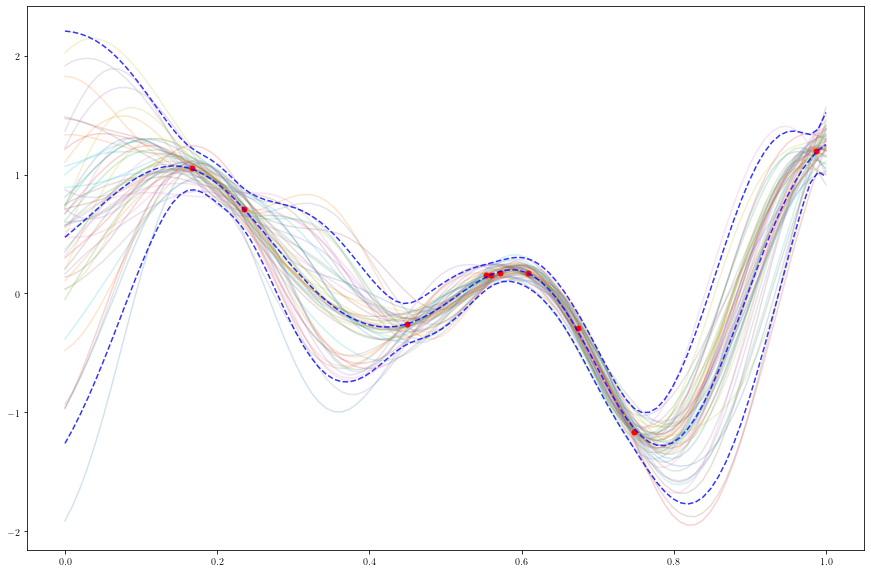

In [21]:
#Ploting the Gaussian Process predictions with some posterior distribution samples
plt.figure(figsize=(15,10))
#plt.plot(x,mpred1,'.')

from torch.distributions.multivariate_normal import MultivariateNormal
for i in range(50):
    i_sample = MultivariateNormal(loc=mpred[:,0], covariance_matrix=Cpred)
    plt.plot(x_test,i_sample.sample(),alpha = 0.2)

plt.plot(x,y,'r.',markersize=10)
plt.plot(x_test,mpred[:,0],'b--',alpha = 0.8)
plt.plot(x_test,mpred[:,0]+2.0*torch.sqrt(torch.diag(Cpred)),'b--',alpha = 0.8)  #This is to plot the standard dev
plt.plot(x_test,mpred[:,0]-2.0*torch.sqrt(torch.diag(Cpred)),'b--',alpha = 0.8)  #This is to plot the standard dev